In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.utils.data
from dataset import SiameseData
from network import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
import torch.optim as optim
from torch.optim import lr_scheduler
from trainer import fit, test_epoch
import matplotlib.pyplot as plt
import numpy as np
from metrics import AccumulatedAccuracyMetric, SiameseAccuracyMetric
import time
import torch.nn as nn
from timeit import default_timer as timer

In [2]:
# parameters
seed = 7
batch_size = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
SIAMESE_PATH = '../models/4-mer/siamese_net.pth'

## Use pretrained model

In [3]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# load the model parameters
model.load_state_dict(torch.load(SIAMESE_PATH))
model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
      (1): PReLU(num_parameters=1)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
      (4): PReLU(num_parameters=1)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (7): PReLU(num_parameters=1)
      (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
      (10): PReLU(num_parameters=1)
    )
    (fc): Sequential(
      (0): Linear(in_features=6912, out_features=384, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=384, out_features=2, bias=True)
    )
  )
)

### Freeze early layers

In [4]:
# Freeze early layers
for param in model.embedding_net.convnet.parameters():
    param.requires_grad = False

### Add new customized layers

In [5]:
n_inputs = model.embedding_net.fc[0].in_features
# model.embedding_net.fc[2] = nn.Linear(n_inputs, 2)
model.embedding_net.fc[0] = nn.Sequential(
    nn.Linear(n_inputs, 3456), nn.PReLU(), nn.Dropout(0.6),
    nn.Linear(3456, 768), nn.PReLU(), nn.Dropout(0.6),
    nn.Linear(768, 384)
)
model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
      (1): PReLU(num_parameters=1)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
      (4): PReLU(num_parameters=1)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (7): PReLU(num_parameters=1)
      (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
      (10): PReLU(num_parameters=1)
    )
    (fc): Sequential(
      (0): Sequential(
        (0): Linear(in_features=6912, out_features=3456, bias=True)
        (1): PReLU(num_parameters=1)
        (2): Dropout(p=0.6)
        (3): Linear(in_features=3456, out_features=768, bias=True)
        (4): PReLU(num_parameters=1)
        (

## Data processing

In [11]:
# parameters
classes = ['Bacteroides_uniformis', 'Bacteroides_xylanisolvens', 'Cohaesibacter sp', 
            'Halomonas sp HL-4', 'Marinobacter sp1', 'M echinaurantiaca', 
            'Muricauda sp', 'Propionibact b', 'Psychrobacter sp', 'Thioclava sp']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

seed = 7
batch_size = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
TRANSFER_PATH = '../models/4-mer/transfer_net.pth'

In [7]:
feature_vectors = pd.read_csv('../data/3-mer/train.csv', header=None)
feature_vectors

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,58.0,33.0,77.0,34.0,48.0,50.0,59.0,35.0,64.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66.0,40.0,91.0,52.0,36.0,34.0,49.0,32.0,74.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69.0,41.0,51.0,64.0,49.0,57.0,56.0,20.0,56.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,33.0,70.0,60.0,51.0,38.0,60.0,31.0,67.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61.0,32.0,53.0,35.0,36.0,49.0,39.0,20.0,55.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10612,252.0,90.0,125.0,144.0,95.0,44.0,39.0,65.0,127.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
10613,135.0,74.0,87.0,117.0,89.0,48.0,37.0,53.0,80.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
10614,92.0,62.0,86.0,92.0,67.0,42.0,52.0,35.0,75.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
10615,105.0,99.0,78.0,86.0,71.0,60.0,72.0,50.0,78.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0


In [8]:
test_vectors = pd.read_csv('../data/test_dataset/3-mer/test.csv', header=None)
test_vectors

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,130.0,66.0,76.0,121.0,58.0,63.0,26.0,59.0,58.0,48.0,...,9.0,2.0,5.0,6.0,5.0,3.0,4.0,3.0,0.0,0.0
1,101.0,67.0,74.0,98.0,54.0,79.0,38.0,51.0,57.0,52.0,...,2.0,0.0,1.0,4.0,2.0,4.0,6.0,2.0,0.0,0.0
2,111.0,56.0,70.0,93.0,41.0,55.0,37.0,34.0,56.0,49.0,...,1.0,2.0,4.0,1.0,3.0,0.0,3.0,0.0,0.0,0.0
3,92.0,36.0,81.0,113.0,52.0,25.0,41.0,58.0,57.0,34.0,...,2.0,5.0,5.0,7.0,6.0,2.0,1.0,2.0,0.0,0.0
4,134.0,74.0,77.0,95.0,85.0,41.0,35.0,61.0,66.0,32.0,...,2.0,4.0,3.0,3.0,3.0,5.0,0.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12170,30.0,33.0,37.0,31.0,34.0,57.0,59.0,8.0,44.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
12171,33.0,42.0,43.0,32.0,34.0,87.0,74.0,25.0,44.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
12172,30.0,43.0,61.0,19.0,36.0,84.0,74.0,28.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
12173,32.0,69.0,51.0,33.0,43.0,89.0,64.0,65.0,41.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


In [9]:
# train data preprocessing
trainset = feature_vectors.values
X_train = trainset[:, :-1]
Y_train = trainset[:, -1]

X_train = preprocessing.MinMaxScaler().fit_transform(X_train)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)

X_train = X_train.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)

# load datasest
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)

In [10]:
# test data preprocessing
testset = test_vectors.values
X_test = testset[:, :-1]
Y_test = testset[:, -1]

X_test = preprocessing.MinMaxScaler().fit_transform(X_test)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_test = X_test.unsqueeze(1)

# construct dataset
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

### Train the transfer model

In [12]:
# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 3, gamma=0.1, last_epoch=-1)
n_epochs = 6
log_interval = 100

In [13]:
# visulization
def plot_model_history(loss_train, loss_test, accuracy_train, accuracy_test):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # loss of model
    axs[0].plot(range(1, len(loss_train) + 1), loss_train)
    axs[0].plot(range(1, len(loss_test) + 1), loss_test)
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(loss_train) + 1), len(loss_train) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    # accuracy of model
    axs[1].plot(range(1, len(accuracy_train) + 1), accuracy_train)
    axs[1].plot(range(1, len(accuracy_test) + 1), accuracy_test)
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(accuracy_train) + 1), len(accuracy_train) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('../images/' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + '.png')

In [14]:
model

SiameseNet(
  (embedding_net): EmbeddingNet(
    (convnet): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
      (1): PReLU(num_parameters=1)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
      (4): PReLU(num_parameters=1)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      (7): PReLU(num_parameters=1)
      (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
      (10): PReLU(num_parameters=1)
    )
    (fc): Sequential(
      (0): Sequential(
        (0): Linear(in_features=6912, out_features=3456, bias=True)
        (1): PReLU(num_parameters=1)
        (2): Dropout(p=0.6)
        (3): Linear(in_features=3456, out_features=768, bias=True)
        (4): PReLU(num_parameters=1)
        (

Train: [0/10617 (0%)]	Loss: 5.422189	Accuracy: 57.03125
Epoch: 1/6. Train set: Average loss: 1.0520	Accuracy: 85.27832721107657
Epoch: 1/6. Validation set: Average loss: 0.2740	Accuracy: 79.76180698151951
Train: [0/10617 (0%)]	Loss: 0.563392	Accuracy: 86.71875
Epoch: 2/6. Train set: Average loss: 0.4562	Accuracy: 86.23905057925968
Epoch: 2/6. Validation set: Average loss: 0.1390	Accuracy: 84.13141683778234
Train: [0/10617 (0%)]	Loss: 0.437741	Accuracy: 90.625
Epoch: 3/6. Train set: Average loss: 0.3416	Accuracy: 88.43364415559951
Epoch: 3/6. Validation set: Average loss: 0.1128	Accuracy: 83.92607802874743
Train: [0/10617 (0%)]	Loss: 0.131845	Accuracy: 87.5
Epoch: 4/6. Train set: Average loss: 0.2731	Accuracy: 88.46190072525195
Epoch: 4/6. Validation set: Average loss: 0.1045	Accuracy: 81.44558521560575
Train: [0/10617 (0%)]	Loss: 0.334458	Accuracy: 85.15625
Epoch: 5/6. Train set: Average loss: 0.2407	Accuracy: 88.48073843835358
Epoch: 5/6. Validation set: Average loss: 0.0914	Accuracy:

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


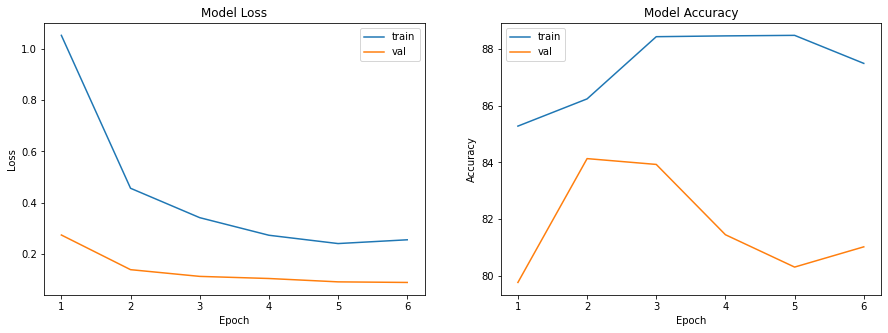

In [15]:
# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), TRANSFER_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)


### Test data using new model

In [16]:
classes = ['Bacteroides_uniformis', 'Bacteroides_xylanisolvens', 'Cohaesibacter sp', 
            'Halomonas sp HL-4', 'Marinobacter sp1', 'M echinaurantiaca', 
            'Muricauda sp', 'Propionibact b', 'Psychrobacter sp', 'Thioclava sp']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

n_classes = 10

In [17]:
# visualization
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(n_classes):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)
    
def plot_embeddings_nolabel(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for seq, target in dataloader:
            if cuda:
                seq = seq.cuda()
            embeddings[k:k + len(seq)] = model.get_embedding(seq).data.cpu().numpy()
            labels[k:k + len(seq)] = target.numpy()
            k += len(seq)
    return embeddings, labels

length of test dataset: 12175
Accuracy  81.01848049281314
confusion matrix:
[[4536. 1551.]
 [ 760. 5328.]]


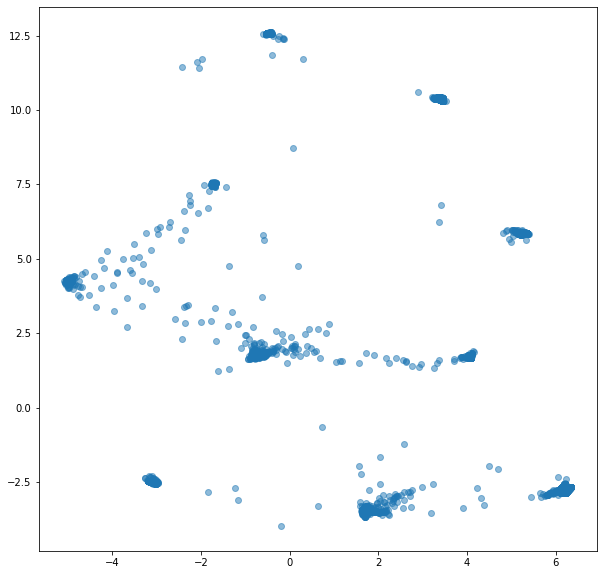

In [18]:
# load the model parameters
model.load_state_dict(torch.load(TRANSFER_PATH))

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

val_loss, metrics = test_epoch(siamese_test_loader, model, loss_fn, cuda, metrics=[SiameseAccuracyMetric()])
print('length of test dataset: ' + str(len(siamese_test_dataset)))
for metric in metrics:
    print(str(metric.name()) + "  " + str(metric.value()))
    print('confusion matrix:')
    print(metric.confusion_matrix())

# plot embedding vectors
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings_nolabel(val_embeddings_cl, val_labels_cl)

### K-means clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, rand_score
from sklearn.metrics.cluster import contingency_matrix, pair_confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score
random_state = 170

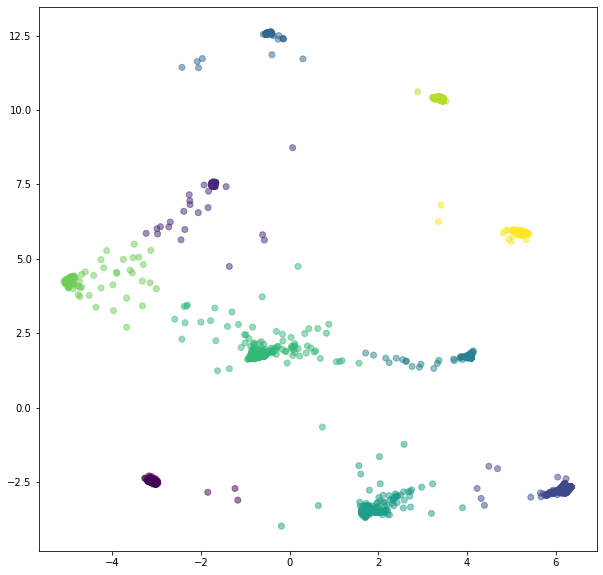

In [20]:
y_pred = KMeans(n_clusters=10, random_state=random_state).fit_predict(val_embeddings_cl)
plt.figure(figsize=(10, 10))
plt.scatter(val_embeddings_cl[:, 0], val_embeddings_cl[:, 1], alpha=0.5, c=y_pred)

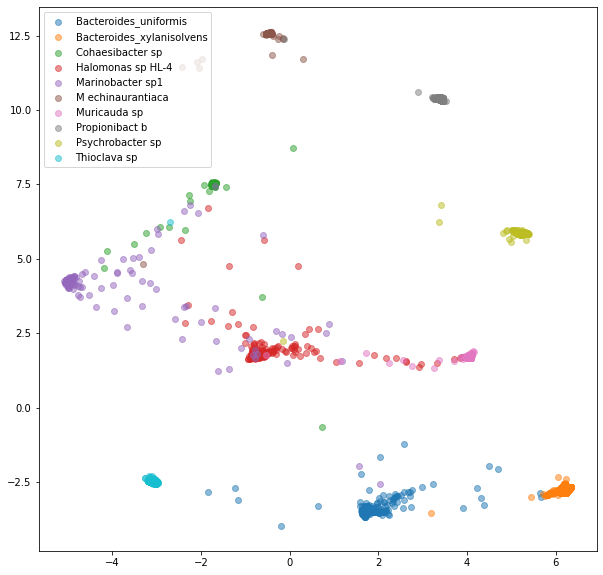

In [21]:
# Ground truth
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [22]:
# evaluation
labels_groundtruth = val_labels_cl
labels = y_pred
print('Contingency Matrix')
print(contingency_matrix(labels_groundtruth, labels))
print('Pair Confusion Matrix')
pm = pair_confusion_matrix(labels_groundtruth, labels)
print(pm)
precision = pm[1][1] / (pm[1][1] + pm[0][1])
recall = pm[1][1] / (pm[1][1] + pm[1][0])
print('Pricision: ' + str(precision))
print('Recall: ' + str(recall))
print('Adjusted Rand Index: ' + str(adjusted_rand_score(labels_groundtruth, labels)))
print('Rand Index: ' + str(rand_score(labels_groundtruth, labels)))
print('Normalized Mutual Information: ' + str(normalized_mutual_info_score(labels_groundtruth, labels)))
print('Homogeneity: ' + str(homogeneity_score(labels_groundtruth, labels)))
print('Completeness ' + str(completeness_score(labels_groundtruth, labels)))
print('V measure ' + str(v_measure_score(labels_groundtruth, labels)))

Contingency Matrix
[[   3    0   10    0    0 1169    0    0    0    0]
 [   0    0 1605    0    0    1    0    0    0    0]
 [   0 1271    0    0    0    0    2    4    0    0]
 [   0    4    0    0   17    0 1038    0    0    0]
 [   0    7    0    0    0    2   22 1080    0    0]
 [   0    0    0 1798    0    0    0    1    1    0]
 [   0    0    0    0  896    0    2    0    0    0]
 [   0    0    0    1    0    0    0    0 1122    0]
 [   0    0    0    0    0    0    1    0    0  878]
 [1239    1    0    0    0    0    0    0    0    0]]
Pair Confusion Matrix
[[132469426    180534]
 [   177304  15391186]]
Pricision: 0.9884062903776847
Recall: 0.9886113553722936
Adjusted Rand Index: 0.9871599903013104
Rand Index: 0.9975857391573046
Normalized Mutual Information: 0.9833201454156917
Homogeneity: 0.9833102926536682
Completeness 0.9833299983751663
V measure 0.9833201454156917


In [24]:
!python maxbin_evaluation_clustering.py

Rand index for each bin:
[1.0, 1.0, 0.9838429626962761, 0.9976525821596244, 0.9665038117653517, 1.0, 0.9726027397260274, 0.9966273235260577, 1.0, 0.9714342523860021, 1.0, 1.0, 1.0, 0.96]
Contingency Matrix
[0 1 2 3 4 5 6 7 8 9]
[[   0    0    0    0  751    0    1    0    0   19    0    0    0   49]
 [   0    0    0    0   13    0   72    0    0 1293    0    0    0    1]
 [   0    0    0    0    0    0    0 1183    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0  290    0  448    0]
 [ 847    0    0    0    0    0    0    2    0    0    0    0    0    0]
 [   0    0    9    0    0 1727    0    0    0    0    0    0    0    0]
 [   0    0    0  851    0    0    0    0    0    0    0    0    0    0]
 [   0    0 1097    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0  794    0    0]
 [   0  942    0    0    0    0    0    0  227    0    0    0    0    0]]
Pair Confusion Matrix
[[100446852     950

### DBSCAN

In [25]:
from sklearn.cluster import DBSCAN

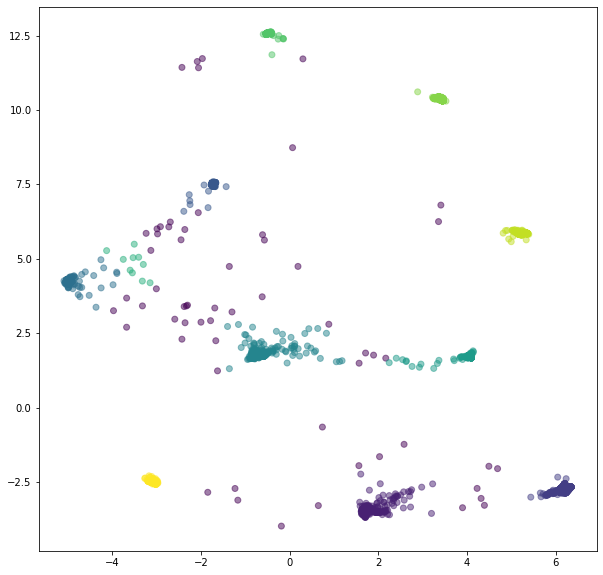

In [34]:
db = DBSCAN(eps=0.6, min_samples=10).fit(val_embeddings_cl)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

plt.figure(figsize=(10, 10))
plt.scatter(val_embeddings_cl[:, 0], val_embeddings_cl[:, 1], alpha=0.5, c=labels)

In [35]:
# evaluation
labels_groundtruth = val_labels_cl
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Contingency Matrix')
print(contingency_matrix(labels_groundtruth, labels))
print('Pair Confusion Matrix')
pm = pair_confusion_matrix(labels_groundtruth, labels)
print(pm)
precision = pm[1][1] / (pm[1][1] + pm[0][1])
recall = pm[1][1] / (pm[1][1] + pm[1][0])
print('Pricision: ' + str(precision))
print('Recall: ' + str(recall))
print('Adjusted Rand Index: ' + str(adjusted_rand_score(labels_groundtruth, labels)))
print('Rand Index: ' + str(rand_score(labels_groundtruth, labels)))
print('Normalized Mutual Information: ' + str(normalized_mutual_info_score(labels_groundtruth, labels)))
print('Homogeneity: ' + str(homogeneity_score(labels_groundtruth, labels)))
print('Completeness ' + str(completeness_score(labels_groundtruth, labels)))
print('V measure ' + str(v_measure_score(labels_groundtruth, labels)))

Estimated number of clusters: 11
Estimated number of noise points: 60
Contingency Matrix
[[  13 1164    5    0    0    0    0    0    0    0    0    0]
 [   0    1 1605    0    0    0    0    0    0    0    0    0]
 [   7    0    0 1266    2    0    0    2    0    0    0    0]
 [  11    0    0    1    0 1032   15    0    0    0    0    0]
 [  20    1    0    3 1067   13    0    7    0    0    0    0]
 [   5    0    0    0    0    0    0    1 1793    1    0    0]
 [   1    0    0    0    0    2  895    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    1 1122    0    0]
 [   2    0    0    0    0    1    0    0    0    0  876    0]
 [   1    0    0    0    0    0    0    0    0    0    0 1239]]
Pair Confusion Matrix
[[132546188    103772]
 [   264954  15303536]]
Pricision: 0.993264754621638
Recall: 0.9829813938281747
Adjusted Rand Index: 0.9867073595880151
Rand Index: 0.9975122800164217
Normalized Mutual Information: 0.9806993396054366
Homogeneity: 0.9859314875393017
Co